In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-competition-2024-for-ukrainians/sample_submission.csv
/kaggle/input/ml-competition-2024-for-ukrainians/train.csv
/kaggle/input/ml-competition-2024-for-ukrainians/test.csv


<h3>Import neccessary libraries</h3>

In [2]:
# import necessary libraries
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st 
import seaborn as sn

from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

<h3>Read data</h3>

In [3]:
train_path = '/kaggle/input/ml-competition-2024-for-ukrainians/train.csv'
test_path = '/kaggle/input/ml-competition-2024-for-ukrainians/test.csv'

train_df = pd.read_csv(train_path, delimiter=',')
test_df = pd.read_csv(test_path, delimiter=',')

In [4]:
train_df.head()

,id,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,NCU06,17.60,Low Fat,0.024795,Household,231.1010,OUT017,2007,Medium,Tier 2,Supermarket Type1,1760.43266
1,1,FDY26,20.50,Regular,0.102226,Dairy,212.6244,OUT017,2007,Medium,Tier 2,Supermarket Type1,101.20160
2,2,FDK21,18.35,Low Fat,0.092238,Snack Foods,250.1092,OUT013,1987,High,Tier 3,Supermarket Type1,2042.61550
3,3,NCN05,12.15,Low Fat,0.043942,Health and Hygiene,182.2950,OUT049,1999,Medium,Tier 1,Supermarket Type1,3103.95960
4,4,FDA47,10.50,Regular,0.042967,Baking Goods,162.4210,OUT035,2004,Small,Tier 2,Supermarket Type1,442.75700


<h3>Merge train and test data into single dataset. It helps to easier manipulate with test and train data</h3>

In [5]:
merged = pd.concat([train_df, test_df])
merged.reset_index(inplace=True)
merged.head()

,index,id,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,0,NCU06,17.60,Low Fat,0.024795,Household,231.1010,OUT017,2007,Medium,Tier 2,Supermarket Type1,1760.43266
1,1,1,FDY26,20.50,Regular,0.102226,Dairy,212.6244,OUT017,2007,Medium,Tier 2,Supermarket Type1,101.20160
2,2,2,FDK21,18.35,Low Fat,0.092238,Snack Foods,250.1092,OUT013,1987,High,Tier 3,Supermarket Type1,2042.61550
3,3,3,NCN05,12.15,Low Fat,0.043942,Health and Hygiene,182.2950,OUT049,1999,Medium,Tier 1,Supermarket Type1,3103.95960
4,4,4,FDA47,10.50,Regular,0.042967,Baking Goods,162.4210,OUT035,2004,Small,Tier 2,Supermarket Type1,442.75700


In [6]:
merged.describe()

,index,id,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,630714.000000,630714.000000,630714.000000,630714.000000,630714.000000,630714.000000,378428.000000
mean,163985.060000,315356.500000,12.808369,0.054535,137.830210,2000.650039,2125.058867
std,101176.656723,182071.593178,4.618032,0.046924,61.036262,6.532276,1667.612362
min,0.000000,0.000000,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,78839.000000,157678.250000,8.775000,0.017311,92.943600,1997.000000,965.364480
50%,157678.000000,315356.500000,12.500000,0.044926,131.231000,2002.000000,1751.827180
75%,236517.000000,473034.750000,16.750000,0.081425,182.360800,2007.000000,2877.301250
max,378427.000000,630713.000000,30.000000,0.328391,266.888400,2009.000000,31224.726950


In [7]:
merged.dtypes

index                          int64
id                             int64
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

<h3>Check for numerical data distributions</h3>

array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Item_Weight'}>],
       [<Axes: title={'center': 'Item_Visibility'}>,
        <Axes: title={'center': 'Item_MRP'}>,
        <Axes: title={'center': 'Outlet_Establishment_Year'}>],
       [<Axes: title={'center': 'Item_Outlet_Sales'}>, <Axes: >,
        <Axes: >]], dtype=object)

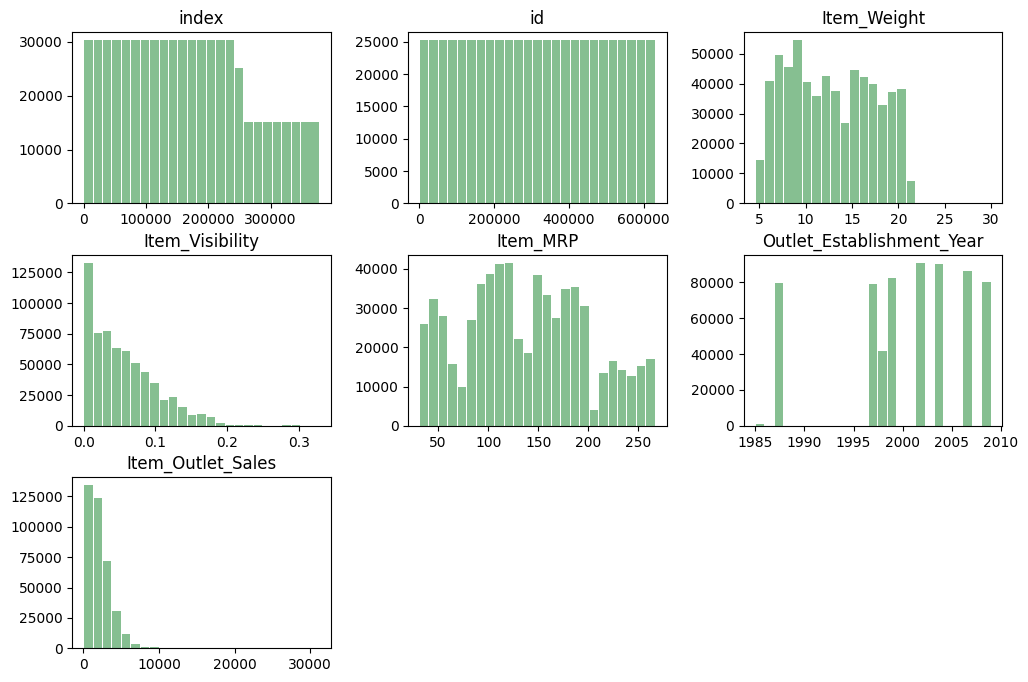

In [8]:
merged.hist(bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

In [9]:
print('Item_fat_content:', list(set(merged['Item_Fat_Content'])))
print('Item_Identifier:', list(set(merged['Item_Identifier'][:10])))
print('Item_Type:', list(set(merged['Item_Type'])))
print('Outlet_Identifier:', list(set(merged['Outlet_Identifier'])))
print('Outlet_Size:', list(set(merged['Outlet_Size'])))
print('Outlet_Location_Type:', list(set(merged['Outlet_Location_Type'])))
print('Outlet_Type:', list(set(merged['Outlet_Type'])))

Item_fat_content: ['Regular', 'low fat', 'LF', 'reg', 'Low Fat']
Item_Identifier: ['FDA47', 'FDT07', 'FDS03', 'NCU06', 'NCN05', 'FDY26', 'NCS06', 'FDK21', 'FDQ20', 'FDQ03']
Item_Type: ['Meat', 'Fruits and Vegetables', 'Canned', 'Breakfast', 'Seafood', 'Frozen Foods', 'Starchy Foods', 'Dairy', 'Health and Hygiene', 'Breads', 'Hard Drinks', 'Others', 'Soft Drinks', 'Snack Foods', 'Household', 'Baking Goods']
Outlet_Identifier: ['OUT027', 'OUT045', 'OUT049', 'OUT018', 'OUT013', 'OUT035', 'OUT046', 'OUT019', 'OUT017', 'OUT010']
Outlet_Size: ['High', 'Small', 'Medium']
Outlet_Location_Type: ['Tier 3', 'Tier 2', 'Tier 1']
Outlet_Type: ['Supermarket Type1', 'Grocery Store', 'Supermarket Type3', 'Supermarket Type2']


In [10]:
# see that Item_fat_content has similar labels
# Low Fat: LF, low fat
# Regular: reg
merged.replace({'Item_Fat_Content': ['LF', 'low fat']}, 'Low Fat', inplace=True)
merged.replace({'Item_Fat_Content': 'reg'}, 'Regular', inplace=True)

<Axes: xlabel='Item_Fat_Content'>

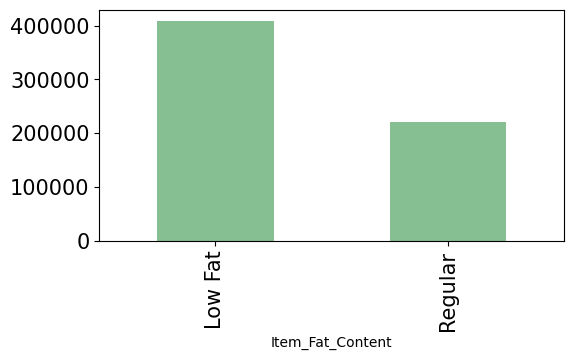

In [11]:
merged['Item_Fat_Content'].value_counts().plot.bar(color = '#86bf91', fontsize = 15, figsize=(6,3))

In [12]:
# also see that item identifier has starts like FD, NC, DR
# try to process item identifiers and check if true
merged['Item_Identifier'].value_counts()[:20]

Item_Identifier
FDU20    803
FDY10    719
FDC56    703
FDE53    700
FDF20    691
FDZ07    690
FDH32    684
FDS33    674
FDX46    673
FDE02    664
FDV10    663
FDU33    662
NCM06    658
FDJ33    658
FDN10    648
FDY21    644
FDX09    644
FDW45    642
FDP38    642
FDY40    636
Name: count, dtype: int64

<Axes: xlabel='Outlet_Identifier'>

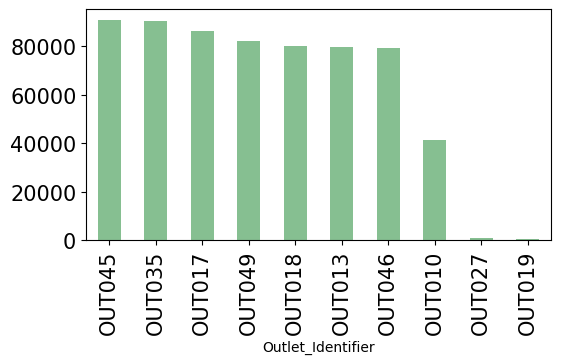

In [13]:
# check Outlet_Identifier
merged['Outlet_Identifier'].value_counts().plot.bar(color = '#86bf91', fontsize = 15, figsize=(6,3))

<h3>Data processing</h3>

<Axes: >

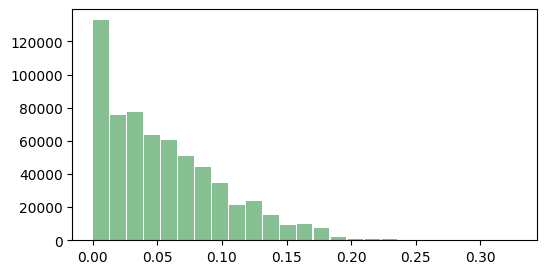

In [14]:
merged['Item_Visibility'].hist(bins=25, grid=False, figsize=(6,3), color='#86bf91', zorder=2, rwidth=0.9)

<Axes: >

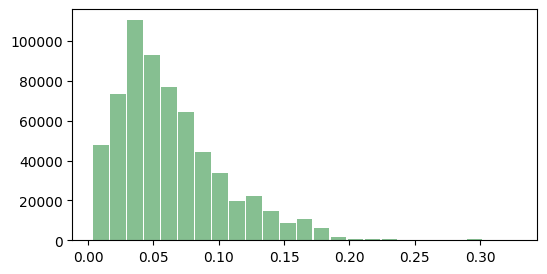

In [15]:
mean_visibility_train = merged.groupby('Item_Identifier')['Item_Visibility'].transform('mean')
merged.loc[merged['Item_Visibility'] == 0.0, 'Item_Visibility'] = mean_visibility_train
merged['Item_Visibility'].hist(bins=25, grid=False, figsize=(6,3), color='#86bf91', zorder=2, rwidth=0.9)

<Axes: >

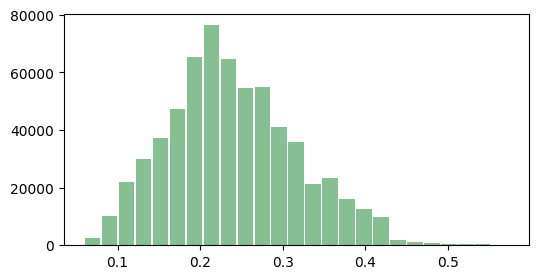

In [16]:
# try to use np.sqrt for Item_Visibility
merged['Item_Visibility'] = merged['Item_Visibility'].apply(lambda x: np.sqrt(x))
merged['Item_Visibility'].hist(bins=25, grid=False, figsize=(6,3), color='#86bf91', zorder=2, rwidth=0.9)

<h3>Feature engineering</h3>

In [17]:
mean_item_fat_content = merged.groupby('Item_Fat_Content')['Item_Outlet_Sales'].mean()
median_item_fat_content = merged.groupby('Item_Fat_Content')['Item_Outlet_Sales'].median()

merged.loc[merged['Item_Fat_Content'] == 'Regular', 'Item_Fat_Content_Mean'] = mean_item_fat_content.get('Regular') / merged['Item_Outlet_Sales'].mean()
merged.loc[merged['Item_Fat_Content'] == 'Low Fat', 'Item_Fat_Content_Mean'] = mean_item_fat_content.get('Low Fat') / merged['Item_Outlet_Sales'].mean()
merged.loc[merged['Item_Fat_Content'] == 'Regular', 'Item_Fat_Content_Median'] = median_item_fat_content.get('Regular') / merged['Item_Outlet_Sales'].median()
merged.loc[merged['Item_Fat_Content'] == 'Low Fat', 'Item_Fat_Content_Median'] = median_item_fat_content.get('Low Fat') / merged['Item_Outlet_Sales'].median()

merged.drop('Item_Fat_Content', axis=1, inplace=True)

In [18]:
mean_outlet_mean = merged.groupby('Outlet_Identifier')['Item_Outlet_Sales'].transform('mean')
mean_outlet_median = merged.groupby('Outlet_Identifier')['Item_Outlet_Sales'].transform('median')

merged['Outlet_Identifier'] = mean_outlet_mean / merged['Item_Outlet_Sales'].mean()
merged['Outlet_Identifier_Median'] = mean_outlet_median / merged['Item_Outlet_Sales'].median()

In [19]:
mean_item_identifier = merged.groupby('Item_Identifier')['Item_Outlet_Sales'].transform('mean')
median_item_identifier = merged.groupby('Item_Identifier')['Item_Outlet_Sales'].transform('median')

merged['Item_Identifier'] = mean_item_identifier / merged['Item_Outlet_Sales'].mean()
merged['Item_Identifier_Median'] = median_item_identifier / merged['Item_Outlet_Sales'].median()

In [20]:
mean_item_type = merged.groupby('Item_Type')['Item_Outlet_Sales'].transform('mean')
median_item_type = merged.groupby('Item_Type')['Item_Outlet_Sales'].transform('median')

merged['Item_Type'] = mean_item_type / merged['Item_Outlet_Sales'].mean()
merged['Item_Type_Median'] = median_item_type / merged['Item_Outlet_Sales'].median()

In [21]:
mean_outlet_size = merged.groupby('Outlet_Size')['Item_Outlet_Sales'].transform('mean')
median_outlet_size = merged.groupby('Outlet_Size')['Item_Outlet_Sales'].transform('median')

merged['Outlet_Size'] = mean_outlet_size / merged['Item_Outlet_Sales'].mean()
merged['Outlet_Size_Median'] = median_outlet_size / merged['Item_Outlet_Sales'].median()

In [22]:
mean_outlet_location_type = merged.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].transform('mean')
median_outlet_location_type = merged.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].transform('median')

merged['Outlet_Location_Type'] = mean_outlet_location_type / merged['Item_Outlet_Sales'].mean()
merged['Outlet_Location_Type_Median'] = median_outlet_location_type / merged['Item_Outlet_Sales'].median()

In [23]:
mean_outlet_type = merged.groupby('Outlet_Type')['Item_Outlet_Sales'].transform('mean')
median_outlet_type = merged.groupby('Outlet_Type')['Item_Outlet_Sales'].transform('median')

merged['Outlet_Type'] = mean_outlet_type / merged['Item_Outlet_Sales'].mean()
merged['Outlet_Type_Median'] = median_outlet_type / merged['Item_Outlet_Sales'].median()

In [24]:
merged.head()

,index,id,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,...,Outlet_Type,Item_Outlet_Sales,Item_Fat_Content_Mean,Item_Fat_Content_Median,Outlet_Identifier_Median,Item_Identifier_Median,Item_Type_Median,Outlet_Size_Median,Outlet_Location_Type_Median,Outlet_Type_Median
0,0,0,1.386263,17.60,0.157464,1.057955,231.1010,1.035402,2007,0.978271,...,1.022331,1760.43266,1.003199,1.009060,1.049347,1.675306,1.117377,0.971434,1.032655,1.029154
1,1,1,1.413445,20.50,0.319729,1.012112,212.6244,1.035402,2007,0.978271,...,1.022331,101.20160,0.994081,0.985116,1.049347,1.484906,0.994998,0.971434,1.032655,1.029154
2,2,2,1.316056,18.35,0.303707,1.021755,250.1092,1.018369,1987,1.018583,...,1.022331,2042.61550,1.003199,1.009060,1.032624,1.279663,1.032806,1.032624,0.938749,1.029154
3,3,3,1.106127,12.15,0.209623,0.988861,182.2950,1.022113,1999,0.978271,...,1.022331,3103.95960,1.003199,1.009060,1.025878,1.121178,1.024263,0.971434,1.020082,1.029154
4,4,4,1.133011,10.50,0.207284,0.946496,162.4210,1.030920,2004,1.018568,...,1.022331,442.75700,0.994081,0.985116,1.041575,1.135620,0.931618,1.024068,1.032655,1.029154


<h3>Replace all object values into numerical</h3>

In [25]:
def object_to_numeric_processor(df, variable):
    object_list = list(set(df[variable]))
    encoder = LabelEncoder()
    encoder.fit(object_list)
    return encoder.transform(df[variable])

In [26]:
object_columns = list(merged.dtypes[merged.dtypes == 'object'].index)

merged = pd.get_dummies(merged, columns=object_columns, drop_first=True)

In [27]:
merged.head()

,index,id,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,...,Outlet_Type,Item_Outlet_Sales,Item_Fat_Content_Mean,Item_Fat_Content_Median,Outlet_Identifier_Median,Item_Identifier_Median,Item_Type_Median,Outlet_Size_Median,Outlet_Location_Type_Median,Outlet_Type_Median
0,0,0,1.386263,17.60,0.157464,1.057955,231.1010,1.035402,2007,0.978271,...,1.022331,1760.43266,1.003199,1.009060,1.049347,1.675306,1.117377,0.971434,1.032655,1.029154
1,1,1,1.413445,20.50,0.319729,1.012112,212.6244,1.035402,2007,0.978271,...,1.022331,101.20160,0.994081,0.985116,1.049347,1.484906,0.994998,0.971434,1.032655,1.029154
2,2,2,1.316056,18.35,0.303707,1.021755,250.1092,1.018369,1987,1.018583,...,1.022331,2042.61550,1.003199,1.009060,1.032624,1.279663,1.032806,1.032624,0.938749,1.029154
3,3,3,1.106127,12.15,0.209623,0.988861,182.2950,1.022113,1999,0.978271,...,1.022331,3103.95960,1.003199,1.009060,1.025878,1.121178,1.024263,0.971434,1.020082,1.029154
4,4,4,1.133011,10.50,0.207284,0.946496,162.4210,1.030920,2004,1.018568,...,1.022331,442.75700,0.994081,0.985116,1.041575,1.135620,0.931618,1.024068,1.032655,1.029154


In [28]:
# standartise outlet_establishment_year using StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit(np.array(merged['Outlet_Establishment_Year']).reshape(-1, 1))
merged['Outlet_Establishment_Year'] = standard_scaler.transform(np.array(merged['Outlet_Establishment_Year']).reshape(-1, 1))

<h3>Check correlation</h3>

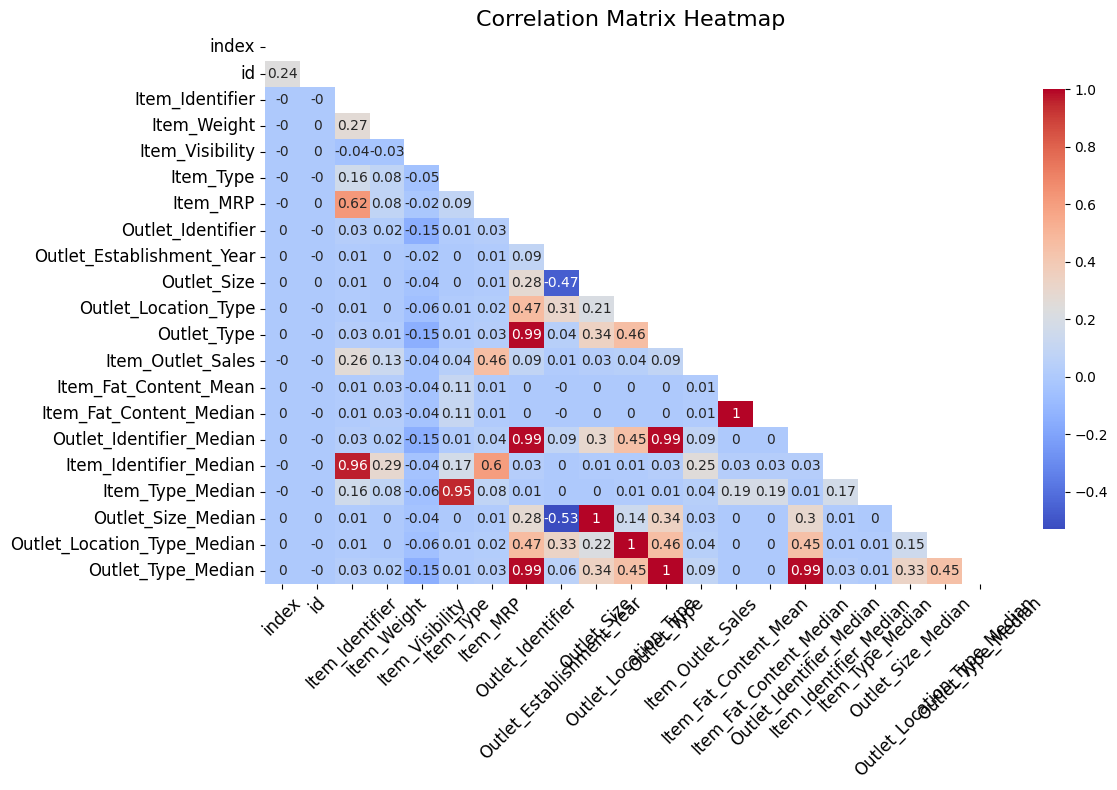

In [29]:
corr_matrix = merged.corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
heatmap = sn.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"size": 10}, cmap='coolwarm', cbar_kws={'shrink': .8})

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

<Axes: >

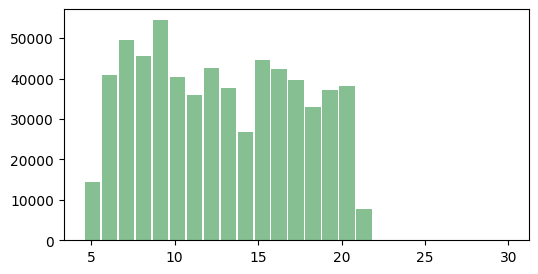

In [30]:
merged['Item_Weight'].hist(bins=25, grid=False, figsize=(6,3), color='#86bf91', zorder=2, rwidth=0.9)

<Axes: >

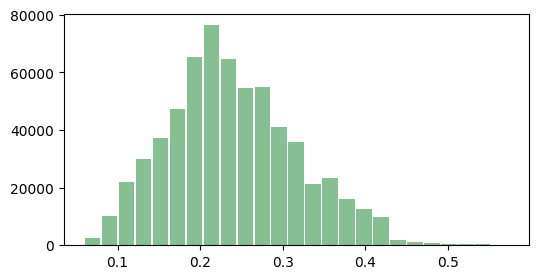

In [31]:
merged['Item_Visibility'].hist(bins=25, grid=False, figsize=(6,3), color='#86bf91', zorder=2, rwidth=0.9)

<h3>Preprocess Item_Outlet_Sales into normal distribution values</h3>

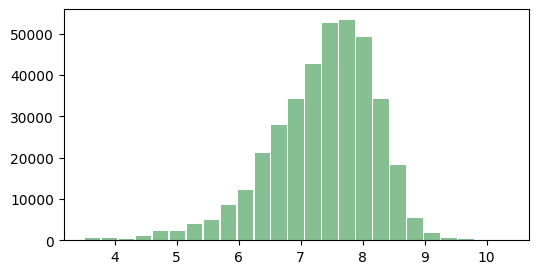

In [32]:
np.log(merged['Item_Outlet_Sales']).hist(bins=25, grid=False, figsize=(6,3), color='#86bf91', zorder=2, rwidth=0.9)
merged['Item_Outlet_Sales'] = merged['Item_Outlet_Sales'].apply(lambda x: np.log(x))

<h3>Split data into test and train</h3>

In [33]:
X_to_test = merged[merged['Item_Outlet_Sales'].isna()].drop('Item_Outlet_Sales', axis=1)

X = merged[~(merged['Item_Outlet_Sales'].isna())].drop('Item_Outlet_Sales', axis=1)
y = merged[~(merged['Item_Outlet_Sales'].isna())]['Item_Outlet_Sales']

<h3>Create and train model</h3>

In [34]:
xgb = XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

xgb.fit(X_train, y_train)

preds= xgb.predict(X_test)

print(f'R2 score: {r2_score(y_test, preds)}')
print(f'MAE score: {mean_absolute_error(y_test, preds)}')
print(f'MSE score: {np.sqrt(mean_squared_error(y_test, preds))}')

R2 score: 0.3193076191316865
MAE score: 0.5106070958560762
MSE score: 0.7040263705998989


In [35]:
X_to_test['Item_Outlet_Sales'] = np.exp(xgb.predict(X_to_test))
X_to_test[['id', 'Item_Outlet_Sales']].set_index('id').to_csv('submission.csv')